In [1]:
# This is an assignment on variational autoencoder (VAE). 
# First import the necessary modules such as torch, numpy, tqdm (for checking progress of loop), and torchvision

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm.notebook import tqdm
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

In [2]:
# Dataset path (default current folder)
# Flag for cuda
# Device to be used, ude GPU if possible
# batch_size (for decent output, and if you have GPU keep it 100)
# see below: at 100 epochs you expect loss to be: Average Loss:  97.84691241587542
# x_dim is the total dimension of input data. In this case, we use MNIST data. It is of 28 x 28 grey scale image, hence, 
# after flattening it will be 784
# latent dimension (size of z, the encoder output): set it to 200. Play with 100, 50, 10, 300, to see the effect
# epochs is the total number of times full training data is passed through enc dec modules of VAE

In [3]:
dataset_path = '/scratch/fk/'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 256

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 5e-4

epochs = 10

In [4]:
# Now import MNIST dataset from torchvision library.
# Also import transforms and dataloader.
# Note that unless the MNIST file exists in your folder, train and test datasets need to be downloaded.
# After downloading, it needs to be loaded using Dataloader.
# Note that shuffling for train data is recomendded (Why?), however, it does not make sense for test data.

In [5]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 5} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [6]:
# Now we are all set to define encoder module.
# We first define the functions that we may use for encoder module with 4 linear layers and finally leakyRELU.
# We also define a forward pass module that defines the encoder.

In [7]:
# class Encoder(nn.Module):
    
#     def __init__(self, input_dim, hidden_dim, latent_dim):
#         super(Encoder, self).__init__()

#         self.FC_input = nn.Linear(input_dim, hidden_dim)
#         self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
#         self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
#         self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
#         self.LeakyReLU = nn.LeakyReLU(0.2)
        
#         self.training = True
        
#     def forward(self, x):
#         h_       = self.LeakyReLU(self.FC_input(x))
#         h_       = self.LeakyReLU(self.FC_input2(h_))
#         mean     = self.FC_mean(h_)
#         log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
#                                                        #             (i.e., parateters of simple tractable normal distribution "q"
        
#         return mean, log_var

In [8]:
# In the following, we implement the same encoder module, but using nn.Sequential
# Note that nn.Sequential gives one output, but we need two: mean and variance. Hence we use shared modules, then separately 
# define mean and var. We prefer to work with log of variance and when required we apply exp.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        # Define the sequential part
        self.shared_layers = nn.Sequential(
            # Write code here
            # define linear and leakyRELU layers, which is shared for mean and var
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2)
        )
        self.training = True
        
        # Define the separate heads for mean and log variance
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        # Apply the shared layers
        h_ = self.shared_layers(x)
        
        # Apply the separate heads
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)
        
        return mean, log_var

In [10]:
# class Decoder(nn.Module):
#     def __init__(self, latent_dim, hidden_dim, output_dim):
#         super(Decoder, self).__init__()
#         # TODO: Fill the follwing code
#         self.FC_hidden = nn.Linear(latent_dim, hidden_dim)      # linear module, input size: latent_dim, output size: hidden_dim
#         self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)     # linear module, input size: hidden_dim, output size: hidden_dim
#         self.FC_output =  nn.Linear(hidden_dim, output_dim)     # linear module, input size: hidden_dim, output size: output_dim
        
#         self.LeakyReLU = nn.LeakyReLU(0.2)
#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, x):
#         # TODO: first pass x through FC_hidden, then followed by LeakyRELU
#         h = self.LeakyReLU(self.FC_hidden(x))
#         # TODO: first pass h through FC_hidden2, then followed by LeakyRELU
#         h = self.LeakyReLU(self.FC_hidden2(h))
#         # TODO: Why did you call LeakyRELU twice, what if it is called only once. Report.
#         #?: We call LeakyReLU twice to bring in non-linearity in our network 

#         # TODO: Finally pass h through FC_output, followed by sigmoid, note that sigmoid is in torch library
#         x_hat = self.sigmoid(self.FC_output(h))
#         return x_hat
        

In [11]:
# TODO: Implement a similar sequential module as done for encoder above for the following decoder. 

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        # TODO: Fill the follwing code
        self.layer = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x_hat = self.layer(x)
        return x_hat
        

In [12]:
# In the following, we implement reparametrization module

In [13]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon  
        # TODO: After sampling epsilon from standard normal, construct z = mean + variance * epsilon
        z = mean + epsilon * var                         # reparameterization trick
        return z
        
                
    def forward(self, x):
        # TODO: pass x through Encoder to get mean and log_var
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        # TODO: after sampling z with reparametrization, pass it through decoder
        x_hat = self.Decoder(z)
        
        return x_hat, mean, log_var

In [14]:
# Initialize encoder and decoders
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

# define the model with encoder and decoder
model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [15]:
from torch.optim import Adam

# define loss
BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    # TODO: define binary cross entropy loss using nn.functional.binary_cross_entropy between x_hat, x, and reduction='sum'
    # See: https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html 
    # Note that since you need to sum, you may use reduction='sum'. You may try 'mean' as well
    reconstruction_loss = BCE_loss(x_hat, x)
    KL = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reconstruction_loss + KL


optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
print("Start training VAE...")
model.train()

for epoch in tqdm(range(200)):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        # print(x.shape)
        x = x.view(-1, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

In [19]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)
        break

  0%|          | 0/40 [00:00<?, ?it/s]

In [20]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

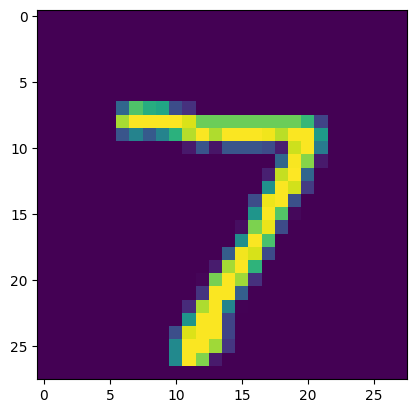

In [21]:
show_image(x, idx=0)

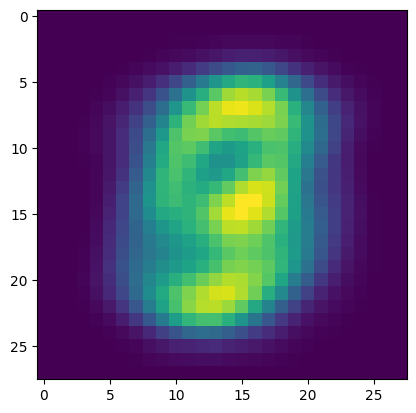

In [22]:
show_image(x_hat, idx=0)

In [23]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [24]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

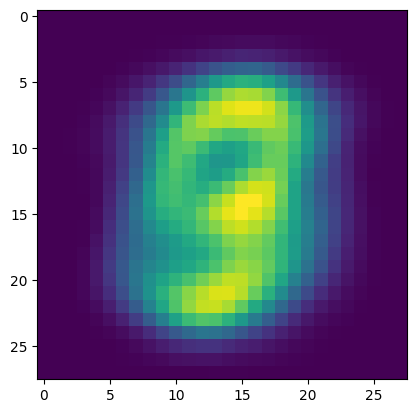

In [25]:
show_image(generated_images, idx=12)

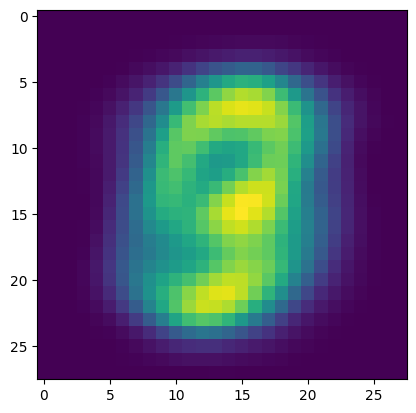

In [26]:
show_image(generated_images, idx=0)

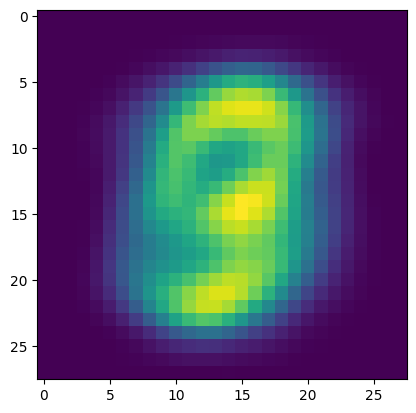

In [27]:
show_image(generated_images, idx=1)